In [29]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
test_path = "../data/UNSW-NB15/UNSW_NB15_testing-set.csv"
df_test = pd.read_csv(test_path)
df_test.head()


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [6]:
feature_cols = [
    "dur","spkts","dpkts","sbytes","dbytes","rate","sttl","dttl","sload","dload",
    "sloss","dloss","sinpkt","dinpkt","smean","dmean","ct_srv_src","ct_state_ttl",
    "ct_dst_ltm","ct_src_dport_ltm"
]

label_col = "label"

X_test = df_test[feature_cols].astype("float32").values
y_test = df_test[label_col].astype("int64").values

X_test.shape, y_test.shape


((175341, 20), (175341,))

In [22]:
checkpoint = torch.load(
    "./model/tranwall.pt",
    map_location="cpu",
    weights_only=False
)

scaler_mean = checkpoint["scaler_mean"]
scaler_scale = checkpoint["scaler_scale"]
input_dim = checkpoint["input_dim"]
model_state = checkpoint["model_state_dict"]


In [23]:
X_test_scaled = (X_test - scaler_mean) / scaler_scale
X_test_tensor = torch.from_numpy(X_test_scaled).float()


In [24]:
class TranWallNet(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=8, num_layers=2, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.cls_head = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = x.unsqueeze(1)
        x = self.transformer(x)
        x = x[:, 0, :]
        logits = self.cls_head(x)
        return logits.squeeze(1)


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TranWallNet(input_dim=input_dim).to(device)
model.load_state_dict(model_state)
model.eval()


TranWallNet(
  (input_proj): Linear(in_features=20, out_features=64, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (cls_head): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [26]:
with torch.no_grad():
    logits = model(X_test_tensor.to(device))
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).long().cpu().numpy()


In [32]:
acc = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds)
print(f"Test Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")


Test Accuracy: 0.8752, F1 Score: 0.9005


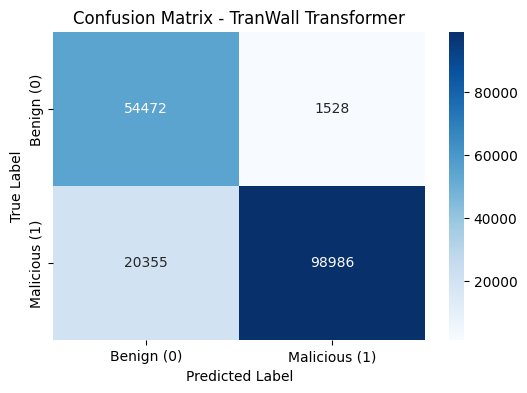

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds)

labels = ["Benign (0)", "Malicious (1)"]

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - TranWall Transformer")
plt.show()
